- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
- [β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework](https://openreview.net/pdf?id=Sy2fzU9gl)
- [Cyclical Annealing Schedule](https://arxiv.org/pdf/1903.10145)
- [Youtube video on Variational Autoencoders](https://www.youtube.com/watch?v=OM95kDPAW-M&t=603s)

In [1]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 
import torch 
import numpy as np
import torchvision
from tqdm import tqdm

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor()
                                ])),
    batch_size=64, shuffle=False)

len(train_loader), len(val_loader)

(938, 157)

In [2]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

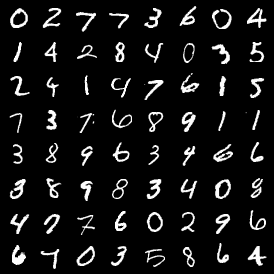

In [3]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8))

# Lets derive the VAE model.  

we have a dataset of images x_1, x_2, ..., x_N

we want to learn a distribution $p_\theta(x)$ so that we can generate new images similar to the training data. 

$$
p_\theta(x) = \int p_\theta(x|z) p(z) dz
$$

we can descritize this integral as summation 

$$
p_\theta(x) = \sum p_\theta(x|z) p(z)
$$

this can also be written as 

$$
p_\theta(x) = \sum_{p(z)} p_\theta(x|z) -- (1)
$$

calculating this is intractable as z is continuous and multidemensional. In the below case we took z=256, so even if we discretize 10 values across each dimension we have 10^256 values. One way to solve this is to make it tractable by conditioning on encoder $q_\phi(z|x)$. Then for a given image we only have one z value 

$$
p_\theta(x) = \sum_{q_\phi(z|x)} p_\theta(x|z) -- (2)
$$

So how do we get from (1) to (2) is what variational autoencoders is about.

lets rewrite the equation (1) again for N images

$$
\sum_{i=1}^{N} p_\theta(x_{i}) = \sum_{i=1}^{N} \sum p_\theta(x_{i}|z) p(z) 
$$

taking log on both sides 

$$
\sum_{i=1}^{N} \log p_\theta(x_{i}) = \sum_{i=1}^{N} \log \sum p_\theta(x_{i}|z) p(z) 
$$

lets multiply and divide by $q_\phi(z|x)$ inside the summation 

$$
\sum_{i=1}^{N} \log p_\theta(x_{i}) = \sum_{i=1}^{N} \log \sum q_\phi(z|x_{i}) \frac{p_\theta(x_{i}|z) p(z)}{q_\phi(z|x_{i})}
$$

Now comes jensin inequality for concave function 

$$
f(\sum_{n} \alpha_{n} x_{n})  \geq \sum_{n} \alpha_{n} f(x_{n})
$$

so here f is log function and $\alpha_{n}$ is $q_\phi(z|x_{i})$ and $x_{n}$ is $p(x_{i}|z) p(z)$ 

$$
\sum_{i=1}^{N} \log p_\theta(x_{i}) = \sum_{i=1}^{N} \log \sum q_\phi(z|x_{i}) \frac{p_\theta(x_{i}|z) p(z)}{q_\phi(z|x_{i})} \geq \sum_{i=1}^{N} \sum q_\phi(z|x_{i}) \log \frac{p_\theta(x_{i}|z) p(z)}{q_\phi(z|x_{i})}
$$

Now we can bring $q_\phi(z|x)$ inside the summation 

$$
\sum_{i=1}^{N} \log p_\theta(x_{i}) \geq \sum_{i=1}^{N} \sum_{q_\phi(z|x_{i})} \log \frac{p_\theta(x_{i}|z) p(z)}{q_\phi(z|x_{i})}
$$

now this is of form log(ab) = log(a) + log(b) where a = $p_\theta(x_{i}|z)$ and b = $p(z)/q_\phi(z|x_{i})$

$$
\sum_{i=1}^{N} \log p_\theta(x_{i}) \geq \sum_{i=1}^{N} \sum_{q_\phi(z|x_{i})} (\log p_\theta(x_{i}|z) + \log \frac{p(z)}{q_\phi(z|x_{i})})
$$

we will move the summation inside 


$$
\sum_{i=1}^{N} \log p_\theta(x_{i}) \geq \sum_{i=1}^{N} \sum_{q_\phi(z|x_{i})} \log p_\theta(x_{i}|z) + \sum_{i=1}^{N} \sum_{q_\phi(z|x_{i})} \log \frac{p(z)}{q_\phi(z|x_{i})}
$$

Now this equation is divided into two parts (1) and (2). From 2, summation over $q_\phi(z|x_{i})$ can be taken inside and make it summation over all z. 

$$
\sum_{i=1}^{N} \log p_\theta(x_{i}) \geq \sum_{i=1}^{N} \sum_{q_\phi(z|x_{i})} \log p_\theta(x_{i}|z) - \sum_{i=1}^{N} \sum_{z} q_\phi(z|x_{i}) \log \frac{q_\phi(z|x_{i})}{p(z)}
$$

so the first term is the reconstruction loss and the second term is the KL divergence.  


### Reconstruction Loss 
given an input image we get q(z|x) from encoder, which when passed through decoder gives us the reconstructed image. maximizing the log likelihood of the input image is equivalent to minimizing the difference between the input and reconstructed image. why?

if we consider a gaussian distribution for p(x|z) then maximizing the log likelihood is equivalent to minimizing the MSE between the input and reconstructed image.  

$$
log(p(x/z)) = \sum_{i=1}^{imgdim} \log p(x_{i}|z) = \sum_{i=1}^{imgdim} \log \frac{1}{\sqrt{2\pi\sigma^{2}}} exp(-\frac{(x_{i}-\mu_{i})^{2}}{2\sigma^{2}})
$$

we can take log of the gaussian function and use the property of log(ab) = log(a) + log(b) 

$$
log(p(x/z)) = \sum_{i=1}^{imgdim} \log p(x_{i}|z) = \sum_{i=1}^{imgdim} \log \frac{1}{\sqrt{2\pi\sigma^{2}}} exp(-\frac{(x_{i}-\mu_{i})^{2}}{2\sigma^{2}}) = \sum_{i=1}^{imgdim} [-\frac{1}{2} log(2\pi) - log(\sigma) - \frac{(x_{i}-\mu_{i})^{2}}{2\sigma^{2}}]
$$

first and 2nd terms are constant so we can drop them, in the third term we have sigma squared which is also a constant in our case so we can drop it as well. 

$$
log(p(x/z)) = \sum_{i=1}^{imgdim} \log p(x_{i}|z) = \sum_{i=1}^{imgdim} - (x_{i}-\mu_{i})^2
$$

so now this is simply the mean squared error between the input and reconstructed image. 


if we consider a bernoulli distribution for p(x|z) then maximizing the log likelihood is equivalent to minimizing the binary cross entropy between the input and reconstructed image.   

$$
log(p(x/z)) = \sum_{i=1}^{imgdim} [\log x_{i} p(x_{i}|z)+ (1-x_{i}) \log (1-p(x_{i}|z))]
$$


## KL Divergence 

From the above derivation we have 

$$
\sum_{i=1}^{N} \sum_{z} q_\phi(z|x_{i}) \log \frac{p(z)}{q_\phi(z|x_{i})}
$$

we can rewrite this as 

$$
\sum_{z} q_\phi(z|x_{i}) \log \frac{q_\phi(z|x_{i})}{p(z)} = KL(q_\phi(z|x_{i}) || p(z)) 
$$

p(z) is normal distribution with mean 0 and variance 1 and q(z|x) is also normal distribution with mean mu and variance sigma. the KL divergence between two gaussian distributions is given by


$$
KL = \log(\sigma_{2}/\sigma_{1}) + \frac{\sigma_{1}^{2} + (\mu_{1}-\mu_{2})^{2}}{2\sigma_{2}^{2}} - \frac{1}{2}
$$

since p(z) sigma_2 = 1 and mu_2 = 0, the equation reduces to 

$$
KL = - \log(\sigma_{1}) + \frac{\sigma_{1}^{2} + \mu_{1}^{2}}{2} - \frac{1}{2}
$$


taking 1/2 common from the equation 

$$
KL = (1/2) [-2*\log(\sigma_{1}) + \sigma_{1}^{2} + \mu_{1}^{2} -1]
$$ 

So finally objective of the VAE is minimize the reconstruction loss - beta * KL divergence. why do we have beta? This is to control the balance between reconstruction loss and KL divergence as KL divergence values are much larger than reconstruction loss in the initial stages of training and this can lead to mode collapse. There are different papers modelling this and we use use a cyclical annealing schedule for beta below. 



In [4]:
# Encoder of a VAE is a standard convolutional neural network. 
# It takes an image as input and outputs the mean and log variance of the latent space. 
# The decoder is another convolutional neural network that takes the latent space as input and outputs an image. 
# The latent space is a continuous space that the encoder maps the input image to. 
# The decoder takes this continuous space and maps it back to an image. 
# The VAE learns to map the input image to the latent space and back to the output image in such a way that the output image is similar to the input image. 
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, n_latent=256):
        super().__init__()
        self.encoder = nn.Sequential(
            #32x32 -> 16x16
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #16x16 -> 8x8
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #8x8 -> 4x4
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #4x4 -> 2x2
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256*2*2, n_latent)
        self.fc_logvar = nn.Linear(256*2*2, n_latent)
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [5]:
enc = Encoder()
mu, logvar = enc(imgs)
mu.shape, logvar.shape


(torch.Size([64, 256]), torch.Size([64, 256]))

In [6]:
count = 0
for p in enc.parameters():
    count += p.numel()
count


913600

In [7]:
class Decoder(nn.Module):
    def __init__(self, n_latent=256):
        super().__init__()
        self.fc = nn.Linear(n_latent, 256*2*2)
        self.decoder = nn.Sequential(
            #2x2 -> 4x4
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #4x4 -> 8x8
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #8x8 -> 16x16
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #16x16 -> 32x32
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 256, 2, 2)
        z = self.decoder(z)
        return z


In [8]:
z = mu + torch.randn_like(mu) * torch.exp(logvar) 
print(z.shape)

torch.Size([64, 256])


In [9]:
dec = Decoder()
dec(z).shape

torch.Size([64, 1, 32, 32])

In [10]:
count = 0
for p in dec.parameters():
    count += p.numel()
count


952481

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class CyclicalAnnealing:
    def __init__(self, total_iterations, num_cycles=4, ramp_proportion=0.5, max_beta=1.0):
        """
        Initialize the cyclical annealing schedule.
        
        Args:
            total_iterations (int): Total number of training iterations
            num_cycles (int): Number of cycles (M in the paper)
            ramp_proportion (float): Proportion used to increase beta within a cycle (R in the paper)
        """
        self.total_iterations = total_iterations
        self.num_cycles = num_cycles
        self.ramp_proportion = ramp_proportion
        self.max_beta = max_beta
        self.steps_per_cycle = total_iterations // num_cycles
        
    def get_beta(self, iteration):
        """
        Calculate beta value for a given iteration.
        
        Args:
            iteration (int): Current iteration number (1-based indexing)
            
        Returns:
            float: Beta value for the current iteration
        """
        # Calculate tau as per equation (7) in the paper
        tau = ((iteration - 1) % self.steps_per_cycle) / self.steps_per_cycle
        
        # If tau exceeds R, return 1 (fixing stage)
        if tau > self.ramp_proportion:
            return self.max_beta
            
        # Otherwise, calculate beta using linear ramping (annealing stage)
        return min(tau / self.ramp_proportion, 1.0) * self.max_beta
    
    def get_beta_schedule(self):
        """
        Generate the complete beta schedule for all iterations.
        
        Returns:
            numpy.ndarray: Array of beta values for each iteration
        """
        return np.array([self.get_beta(i+1) for i in range(self.total_iterations)])
    
    def plot_schedule(self, save_path=None):
        """
        Plot the beta schedule.
        
        Args:
            save_path (str, optional): Path to save the plot. If None, displays the plot.
        """
        betas = self.get_beta_schedule()
        iterations = np.arange(1, len(betas) + 1)
        
        plt.figure(figsize=(5, 3))
        plt.plot(iterations, betas, 'b-', label='Beta')
        plt.grid(True, alpha=0.3)
        plt.xlabel('Iteration')
        plt.ylabel('Beta')
        plt.title('Cyclical Annealing Schedule')
        plt.legend()
        
        # Add vertical lines to show cycle boundaries
        for i in range(1, self.num_cycles):
            plt.axvline(x=i * self.steps_per_cycle, color='r', linestyle='--', alpha=0.3)
            
        if save_path:
            plt.savefig(save_path)
        plt.show()

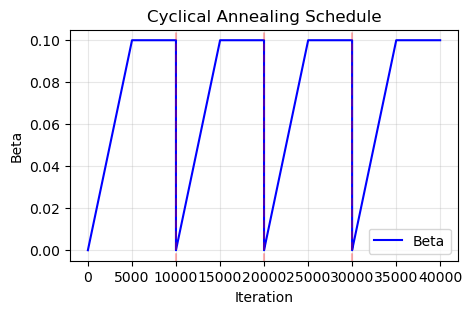

In [12]:
model = CyclicalAnnealing(total_iterations=40000, num_cycles=4, ramp_proportion=0.5, max_beta=0.1)
model.plot_schedule()


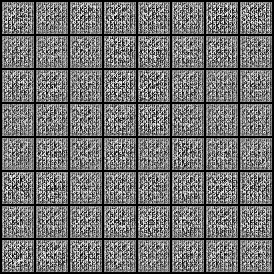

In [13]:
class VAE(nn.Module):
    def __init__(self, n_latent=128, device='mps'):
        super().__init__()
        self.n_latent = n_latent
        self.encoder = Encoder(n_latent)
        self.decoder = Decoder(n_latent)
        self.device = device    

    def forward(self, x, training=True):
        mu, logvar = self.encoder(x)
        if training:
            z = mu + (torch.randn_like(mu) * torch.exp(0.5 * logvar) * 1.2 )
        else:
            z = mu
        return self.decoder(z), mu, logvar
    
    def generate(self, n_samples):
        with torch.no_grad():
            z = torch.randn(n_samples, self.n_latent).to(self.device)
        return self.decoder(z)
    
    
    def loss_function(self, recon_x, x, mu, logvar, beta):
        #MSE = torch.nn.functional.mse_loss(recon_x, x)
        BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + beta * KLD, BCE, KLD

vae = VAE(device='mps')
vae.to(device='mps')

output, _, _ = vae(imgs.to(device='mps'), training=False)
output.shape
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(output.view(64, 1, 32, 32).detach().cpu(), nrow=8))


In [14]:
count = 0
for p in vae.parameters():
    count += p.numel()
count


1472609

In [15]:
epochs = 20
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)

total_iterations = epochs * len(train_loader)
beta_schedule = CyclicalAnnealing(total_iterations=total_iterations, num_cycles=4, ramp_proportion=0.5, max_beta=0.1)

iter = 0 
train_loss = []
val_loss = []
for epoch in range(epochs):
    vae.train()
    with tqdm(train_loader, total=len(train_loader), desc="Training", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device='mps')
            recon_batch, mu, logvar = vae(x)
            beta = beta_schedule.get_beta(iter)
            loss, bce, kld = vae.loss_function(recon_batch, x, mu, logvar, beta)
            #Add loss to the progress bar
            pbar.set_postfix(loss=loss.item(), bce=bce.item(), kld=kld.item(), beta=beta, mu=mu.mean().item(), logvar=logvar.exp().mean().item())
            train_loss.append([loss.item(), bce.item(), kld.item(), beta, mu.mean().item(), logvar.exp().mean().item()])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iter += 1
    
    vae.eval()
    with tqdm(val_loader, total=len(val_loader), desc="Validating", leave=False) as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device='mps')
            recon_batch, mu, logvar = vae(x, training=False)
            #during val, beta is 0
            loss, bce, kld = vae.loss_function(recon_batch, x, mu, logvar, 0)
            val_loss.append([loss.item(), bce.item(), kld.item(), 0, mu.mean().item(), logvar.exp().mean().item()])
            pbar.set_postfix(loss=loss.item(), bce=bce.item(), kld=kld.item(), beta=0, mu=mu.mean().item(), logvar=logvar.exp().mean().item())
    
    print(f'Epoch {epoch+1}/{epochs}, iter: {iter}, Train Loss: {np.mean(train_loss, axis=0)[0]:.4f}, Val Loss: {np.mean(val_loss, axis=0)[0]:.4f}, Train BCE: {np.mean(train_loss, axis=0)[1]:.4f}, Val BCE: {np.mean(val_loss, axis=0)[1]:.4f}, Train KLD: {np.mean(train_loss, axis=0)[2]:.4f}, Val KLD: {np.mean(val_loss, axis=0)[2]:.4f}, Train mu: {np.mean(train_loss, axis=0)[4]:.4f}, Val mu: {np.mean(val_loss, axis=0)[4]:.4f}, Train logvar: {np.mean(train_loss, axis=0)[5]:.4f}, Val logvar: {np.mean(val_loss, axis=0)[5]:.4f}')

    #Generate some images
    samples = vae.generate(64)
    generated_imgs = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(samples.view(64, 1, 32, 32).detach().cpu(), nrow=8))
    generated_imgs.save(f'generated/vae_samples_{epoch+1}.png')



Training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/20, iter: 938, Train Loss: 155.7470, Val Loss: 89.5834, Train BCE: 129.7801, Val BCE: 89.5834, Train KLD: 1800.6062, Val KLD: 977.9233, Train mu: 0.0026, Val mu: 0.0020, Train logvar: 0.7912, Val logvar: 0.8899


Epoch 2/20, iter: 1876, Train Loss: 157.3725, Val Loss: 95.9341, Train BCE: 123.3546, Val BCE: 95.9341, Train KLD: 1262.5524, Val KLD: 768.8201, Train mu: 0.0014, Val mu: 0.0034, Train logvar: 0.8550, Val logvar: 0.9126


Epoch 3/20, iter: 2814, Train Loss: 163.1520, Val Loss: 101.3894, Train BCE: 126.1630, Val BCE: 101.3894, Train KLD: 993.2551, Val KLD: 659.1387, Train mu: 0.0009, Val mu: 0.0024, Train logvar: 0.8857, Val logvar: 0.9249


Epoch 4/20, iter: 3752, Train Loss: 166.0562, Val Loss: 104.2506, Train BCE: 127.8626, Val BCE: 104.2506, Train KLD: 849.4606, Val KLD: 600.3230, Train mu: 0.0007, Val mu: 0.0012, Train logvar: 0.9027, Val logvar: 0.9322


Epoch 5/20, iter: 4690, Train Loss: 167.5548, Val Loss: 105.8329, Train BCE: 128.6232, Val BCE: 105.8329, Train KLD: 763.3352, Val KLD: 561.7986, Train mu: 0.0006, Val mu: 0.0009, Train logvar: 0.9132, Val logvar: 0.9371


Epoch 6/20, iter: 5628, Train Loss: 159.3699, Val Loss: 103.1689, Train BCE: 123.7046, Val BCE: 103.1689, Train KLD: 813.8591, Val KLD: 603.0714, Train mu: 0.0005, Val mu: 0.0014, Train logvar: 0.9135, Val logvar: 0.9359


Epoch 7/20, iter: 6566, Train Loss: 157.8826, Val Loss: 102.3574, Train BCE: 121.6355, Val BCE: 102.3574, Train KLD: 794.3259, Val KLD: 597.4259, Train mu: 0.0004, Val mu: 0.0014, Train logvar: 0.9172, Val logvar: 0.9372


Epoch 8/20, iter: 7504, Train Loss: 159.2638, Val Loss: 102.6125, Train BCE: 121.7631, Val BCE: 102.6125, Train KLD: 756.2368, Val KLD: 580.9746, Train mu: 0.0004, Val mu: 0.0010, Train logvar: 0.9214, Val logvar: 0.9389


Epoch 9/20, iter: 8442, Train Loss: 160.5409, Val Loss: 103.0210, Train BCE: 122.1353, Val BCE: 103.0210, Train KLD: 722.9280, Val KLD: 566.3835, Train mu: 0.0004, Val mu: 0.0008, Train logvar: 0.9250, Val logvar: 0.9406


Epoch 10/20, iter: 9380, Train Loss: 161.5352, Val Loss: 103.3133, Train BCE: 122.4324, Val BCE: 103.3133, Train KLD: 696.0123, Val KLD: 554.3485, Train mu: 0.0003, Val mu: 0.0009, Train logvar: 0.9279, Val logvar: 0.9419


Epoch 11/20, iter: 10318, Train Loss: 157.2529, Val Loss: 101.8802, Train BCE: 119.9598, Val BCE: 101.8802, Train KLD: 729.1804, Val KLD: 578.4299, Train mu: 0.0004, Val mu: 0.0007, Train logvar: 0.9277, Val logvar: 0.9412


Epoch 12/20, iter: 11256, Train Loss: 156.3466, Val Loss: 101.2720, Train BCE: 118.7849, Val BCE: 101.2720, Train KLD: 725.8546, Val KLD: 577.6467, Train mu: 0.0003, Val mu: 0.0005, Train logvar: 0.9289, Val logvar: 0.9416


Epoch 13/20, iter: 12194, Train Loss: 157.1791, Val Loss: 101.3061, Train BCE: 118.8302, Val BCE: 101.3061, Train KLD: 708.9079, Val KLD: 569.9423, Train mu: 0.0003, Val mu: 0.0004, Train logvar: 0.9306, Val logvar: 0.9425


Epoch 14/20, iter: 13132, Train Loss: 158.0392, Val Loss: 101.4008, Train BCE: 119.0606, Val BCE: 101.4008, Train KLD: 691.9610, Val KLD: 562.2891, Train mu: 0.0003, Val mu: 0.0005, Train logvar: 0.9322, Val logvar: 0.9433


Epoch 15/20, iter: 14070, Train Loss: 158.7777, Val Loss: 101.5343, Train BCE: 119.2755, Val BCE: 101.5343, Train KLD: 677.0521, Val KLD: 556.0882, Train mu: 0.0003, Val mu: 0.0005, Train logvar: 0.9336, Val logvar: 0.9440


Epoch 16/20, iter: 15008, Train Loss: 155.8838, Val Loss: 100.5865, Train BCE: 117.6511, Val BCE: 100.5865, Train KLD: 700.8955, Val KLD: 572.5465, Train mu: 0.0003, Val mu: 0.0004, Train logvar: 0.9333, Val logvar: 0.9438


Epoch 17/20, iter: 15946, Train Loss: 155.2399, Val Loss: 100.1397, Train BCE: 116.8559, Val BCE: 100.1397, Train KLD: 700.4734, Val KLD: 572.6475, Train mu: 0.0003, Val mu: 0.0005, Train logvar: 0.9339, Val logvar: 0.9440


Epoch 18/20, iter: 16884, Train Loss: 155.8426, Val Loss: 100.1407, Train BCE: 116.8842, Val BCE: 100.1407, Train KLD: 690.1840, Val KLD: 567.9002, Train mu: 0.0003, Val mu: 0.0005, Train logvar: 0.9348, Val logvar: 0.9445


Epoch 19/20, iter: 17822, Train Loss: 156.5041, Val Loss: 100.1701, Train BCE: 117.0648, Val BCE: 100.1701, Train KLD: 679.1723, Val KLD: 563.2248, Train mu: 0.0003, Val mu: 0.0004, Train logvar: 0.9358, Val logvar: 0.9450


Epoch 20/20, iter: 18760, Train Loss: 157.0945, Val Loss: 100.2232, Train BCE: 117.2469, Val BCE: 100.2232, Train KLD: 669.0169, Val KLD: 558.4684, Train mu: 0.0003, Val mu: 0.0005, Train logvar: 0.9367, Val logvar: 0.9455


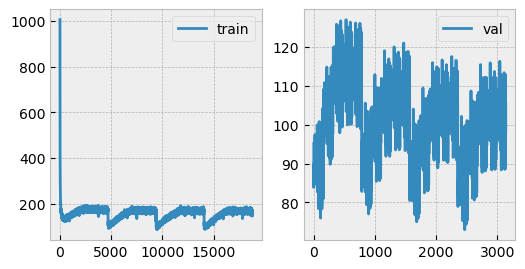

In [16]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

#overall loss plotting 
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax.flat[0].plot(np.asarray(train_loss)[:, 0], label='train') 
ax.flat[1].plot(np.asarray(val_loss)[:, 0], label='val')
ax.flat[0].legend()
ax.flat[1].legend()
plt.show()

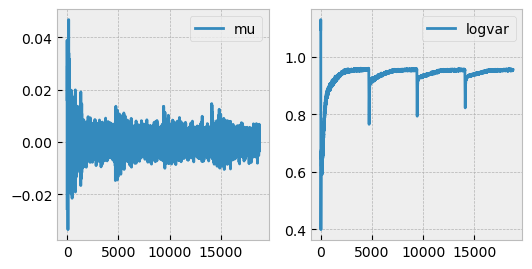

In [23]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

#plotting train mu and logvar
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax.flat[0].plot(np.asarray(train_loss)[:, 4], label='mu') 
ax.flat[1].plot(np.asarray(train_loss)[:, 5], label='logvar')
ax.flat[0].legend()
ax.flat[1].legend()
plt.show()

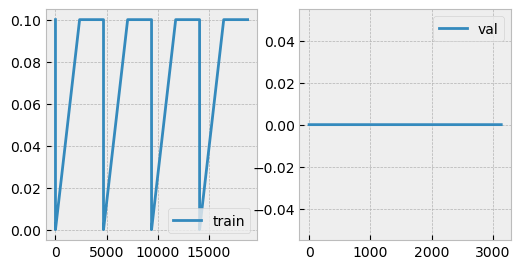

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax.flat[0].plot(np.asarray(train_loss)[:, 3], label='train')
ax.flat[1].plot(np.asarray(val_loss)[:, 3], label='val')
ax.flat[0].legend()
ax.flat[1].legend()
plt.show()


In [18]:
mu, logvar = vae.encoder(imgs.to(device='mps'))
mu.shape, logvar.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [19]:
mu.mean(), logvar.exp().mean()


(tensor(0.0006, device='mps:0', grad_fn=<MeanBackward0>),
 tensor(0.9544, device='mps:0', grad_fn=<MeanBackward0>))

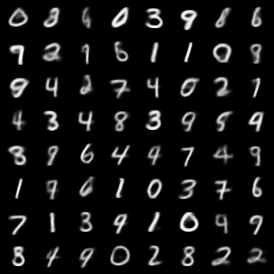

In [20]:
# Generate some images
samples = vae.generate(64)
generated_imgs = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(samples.view(64, 1, 32, 32).detach().cpu(), nrow=8))
generated_imgs

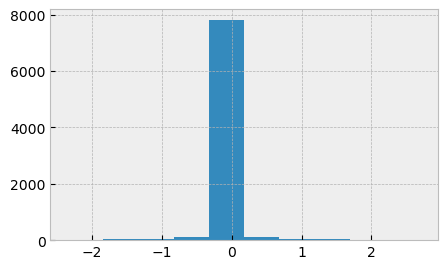

In [21]:
plt.figure(figsize=(5, 3))
plt.hist(mu.detach().cpu().numpy().flatten())
plt.show()

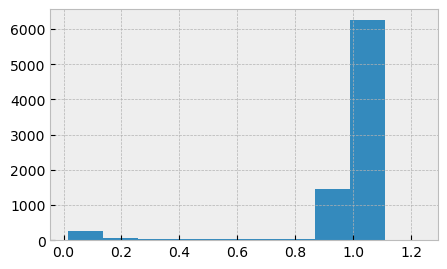

In [22]:
plt.figure(figsize=(5, 3))
plt.hist(logvar.exp().detach().cpu().numpy().flatten())
plt.show()
